### Walk Forward UIP
+ Modification of the original strategy
+ Doing a walk-forward cross-validation
+ Use time-series split of the monthly factor/returns 
+ At each step, trade based on what our model c
+ 

In [134]:
from math import floor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import TimeSeriesSplit
from sklearn import tree
import datetime as datetime


import quandl as ql
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib

%matplotlib inline

In [135]:
ds_currency = xr.open_zarr('currency_pairs_uip')

In [136]:
df_currency = ds_currency.to_dataframe().unstack(level=1)
df_currency.columns = df_currency.columns.droplevel(0)
df_currency = df_currency.rename_axis(None, axis=1)
df_currency.head()

,aus_usd,cad_usd,eur_usd,jpy_usd,usd_gbp
Date,,,,,
2004-01-02,0.7576,1.2900,1.2592,106.95,1.7902
2004-01-05,0.7682,1.2803,1.2679,106.10,1.8085
2004-01-06,0.7702,1.2824,1.2773,106.20,1.8245
2004-01-07,0.7685,1.2884,1.2665,106.19,1.8193
2004-01-08,0.7755,1.2790,1.2772,106.17,1.8338


In [144]:
def compute_returns(period_df, pair):
    logged = np.log(1 + period_df.pct_change()).rename({pair: 'log_returns'})
    return logged

def compute_reversal(period_df, period, mu, sigma):
    
    reversal = (period_df.shift(period) - mu)/sigma
    return reversal

def compute_momentum(period_df, lag_start, lag_end):
    momentum = period_df.shift(lag_start) - period_df.shift(lag_end)
    return momentum

def compute_factors(df,pair):
    '''
    Computes momentum and mean reversal factors 
    as well as log returns for each currency pair and period
    
    Parameters
    ==========
    df: pd.Dataframe of date by currency price
    
    
    Returns
    =======
    tuple of monthly data, mu, sigma and factor and returns dataframe
    
    '''
    
    mu = df.mean()
    sigma = df.std()
    
    df_monthly = df.resample('BM').apply(lambda x: x[-1])
    
    logged = np.log(1 + df_monthly.pct_change()).rename({pair: 'log_returns'})
    reversal = (df_monthly.shift(1) - mu)/sigma
    momentum = df_monthly.shift(1) - df_monthly.shift(4)
    
    ctd = pd.concat([reversal,momentum,logged],axis=1)
    ctd.columns  = ['reversal', 'momentum', 'logged_returns']
    ctd = ctd.dropna()
    
    return ctd


def compute_OLS(res, train_index, test_index, pair):
    '''
    Parameters
    ==========
    df: pd.Dataframe of period by currency_pair
    pair: str of currency pair
    
    
    Returns
    =======
    dictionary of pd.Series of predicted returns and sklearn.LinearRegression fitted model
    
    
    '''

    X_train = res[:train_index[-1]][['reversal', 'momentum']]
    X_test = res[train_index[-1]:][['reversal', 'momentum']]
    y_train = res[:train_index[-1]]['logged_returns']
    y_test = res[train_index[-1]:]['logged_returns']
    
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    model.predict(X_test)
    pred_returns = pd.Series(model.predict(X_test).flatten(), index=y_test.index, name=pair)
    
    return pred_returns
    
def generate_trades(predictions_df):
    '''
    Takes a dataframe of period returns by currency pair
    sorts them from highest to lowest and then assigns a value of 
    1/-1 to the highest/lowest values for each period. 
    
    Long/short positions are not required. If the worst performing of 
    the period is positive, only a long is taken. Similarly, if all 
    period returns were negative only the most negative receives is marked 
    -1, indicating a short position. 
    
    The trades are generated for the out of sample period. 
    
    Parameters
    ==========
    predictions_df: pd.DataFrame of period by currency pair 
    
    
    Returns
    =======
    pd.DataFrame of period by currency pair
    '''
    trades = []
    for i, row in predictions_df.iterrows():
        _sorted = row.sort_values(axis=0,ascending=False)
        #for condition that they the long is positive and the short is negative
        if _sorted[0]*_sorted[-1] < 0:
            trade = {_sorted.index[0]: 1,_sorted.index[-1]: -1}

        elif _sorted[0] and _sorted[-1] > 0:
            trade = {_sorted.index[0]: 1}

        else: 
            trade = {_sorted.index[-1]: -1}
        trades.append(trade)
        
    return pd.DataFrame(trades, index=predictions_df.index)

In [145]:
tscv = TimeSeriesSplit(n_splits=10)
fold = 1
all_trades = []

for train_index, test_index in tscv.split(res):
    pred_list = []
    for i in df_currency.columns:
        df = df_currency[i]
        #this is recomputing unnecessarily for each time step but whatever
        res = compute_factors(df, i)
        #set up data
        #generate period/pair specific prediction
        pred_list.append(compute_OLS(res, train_index, test_index, i))
    #set up all pair predictions
    preds = pd.concat(pred_list, axis =1)
    #determine our trades
    trades = generate_trades(preds)
    all_trades.append(trades)

trade_df = pd.concat(all_trades, axis=0)

In [147]:
monthly_resampled = df_currency.resample('BM').apply(lambda x: x[-1])
all_returns = []
for i in monthly_resampled.columns:
    all_returns.append(compute_returns(monthly_resampled[i], i))

In [148]:
returns_df = pd.concat(all_returns,axis=1).loc[trade_df.head().index[0]:,]*trade_df

In [149]:
returns_df['summed_returns'] = returns_df.sum(axis=1)

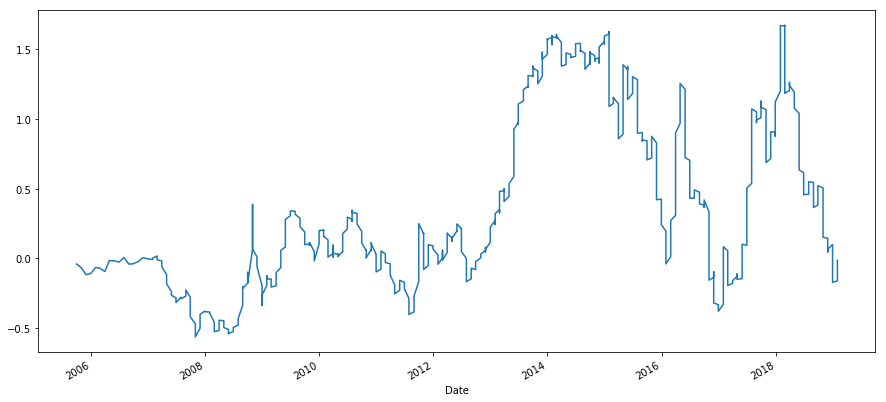

In [150]:
fig = plt.figure(figsize=(15,7))
returns_df['summed_returns'].cumsum().plot()